In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba
import wandb

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types


from oracle_utils import AlgoResults
from sinkhorn import Sinkhorn
from transport_problem import OptimParams, DualOracle, HyperParams
from sinkhorn_appendix import ustm_sinkhorn_mincost_mcf, OracleSinkhornStacker
from get_graph import get_graph_by_name

In [2]:
BIG_CONST_FOR_FAKE_EDGES = 40

In [3]:
net_df, corrs = get_graph_by_name(['SiouxFalls', 'Berlin', 'Chicago', 'Anaheim'][3])
graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

graph type:  Anaheim
3.579924242


In [4]:
from transport_problem import HyperParams, DualOracle, OptimParams
l = np.sum(corrs, axis=1)
l = np.maximum(l, 1e-6)
w = np.sum(corrs, axis=0)
w = np.maximum(w, 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, l, w, params, net_df=net_df)
oracle_stacker = OracleSinkhornStacker(oracle, graph, sources, targets, l, w, params)

In [5]:
t, history, sinkhistory = ustm_sinkhorn_mincost_mcf(oracle_stacker,  eps_abs=1e-2, eps_cons_abs=1e-4, max_iter=500, stop_by_crit=False)

52.24705881856717 1.5133372668436754e-06
start optimizing


100%|█████████████████████████████████████████| 500/500 [01:06<00:00,  7.51it/s]


In [6]:
# history

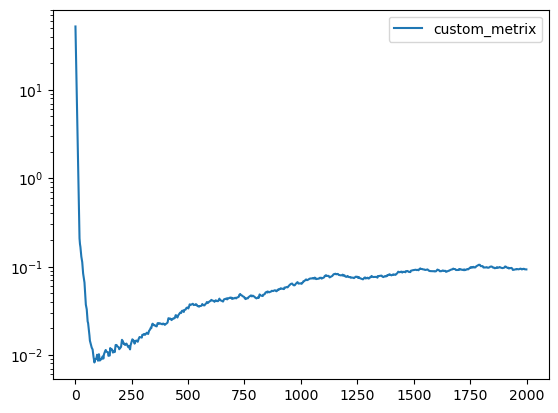

In [7]:
x = history.history_count_calls
dual_gap = history.history_dual_gap
dual_gap_clipped = np.maximum(0, dual_gap)
la_mu_end_norm = np.linalg.norm(np.hstack([oracle_stacker.optim_params.la, oracle_stacker.optim_params.mu]))

metric = 2 * np.array(history.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped
plt.plot(x, metric, label='custom_metrix')
plt.yscale('log')
plt.legend()
plt.show()

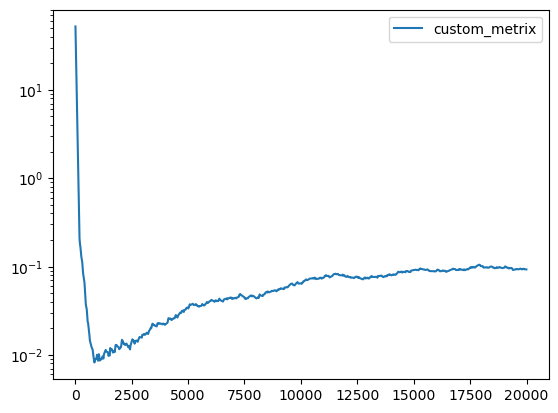

In [8]:
x = sinkhistory.history_count_calls
dual_gap = sinkhistory.history_dual_gap
dual_gap_clipped = np.maximum(0, dual_gap)
la_mu_end_norm = np.linalg.norm(np.hstack([oracle_stacker.optim_params.la, oracle_stacker.optim_params.mu]))

metric = 2 * np.array(history.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped
plt.plot(x, metric, label='custom_metrix')
plt.yscale('log')
plt.legend()
plt.show()

In [26]:
# wandb.finish()

In [45]:
import pickle

In [47]:
with open('history.pickle', 'wb') as f:
    f.write(pickle.dumps(history))

In [ ]:
# plt.plot(xs, dgap_log, label="dual gap")
# plt.legend()
# plt.yscale("log")
# plt.rcParams['figure.dpi']=300
# plt.show()


plt.plot(history_prime_values, label="history prime function")
plt.legend()
plt.show()

plt.plot(history_dual_values, label="history dual function")
plt.legend()
plt.show()

In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())

In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())